In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import pickle
import seaborn as sns
import skimage
import sys

ampis_root = pathlib.Path('../../../src/')
assert ampis_root.is_dir()
sys.path.append(str(ampis_root))
from ampis.analyze import ordinal_hist_distance

In [2]:
with open('powder_particle_cval_validation_instance_sets.pickle', 'rb') as f:
    particles = pickle.load(f)



In [3]:
instances.keys()

dict_keys(['gt_val', 'pred_val'])

In [4]:
gt = instances['gt_val']
pred = instances['pred_val']

gt_rprops = []
for x in gt:
    for y in x:
        gt_rprops.append(y.rprops)
pred_rprops = []
for x in pred:
    for y in x:
        pred_rprops.append(y.rprops)
        
df_gt = pd.concat(gt_rprops)
df_pred = pd.concat(pred_rprops)

In [12]:
len(df_gt), len(df_pred)

(1360, 1149)

In [5]:
def quickplot(key, x=df_gt, y=df_pred,log=False, bin_width_k=1):
    
    
    xdata = x[key].to_numpy(dtype=np.float)
    ydata = y[key].to_numpy(dtype=np.float)
    
    colors = sns.color_palette('bright', 2)
    
    if log:
        xdata = np.log10(xdata)
        ydata = np.log10(ydata)
    
    
    _, xbins = np.histogram(xdata)
    _, ybins = np.histogram(ydata)
    
    bin_min = min(xbins.min(), ybins.min())
    bin_max = max(xbins.max(), ybins.max())
    
    xbinsize = xbins[1]-xbins[0]
    ybinsize = ybins[1]-ybins[0]
    minbinsize = min(xbinsize, ybinsize)
    
    nbins = int(((bin_max-bin_min)/minbinsize+1)*bin_width_k)
    
    new_bins = np.linspace(bin_min, bin_max, num =nbins)
    
    gt_hist, gt_bins = np.histogram(xdata, bins=new_bins)
    pred_hist, pred_bins = np.histogram(ydata, bins=new_bins)
    
    
    fig, ax = plt.subplots(figsize=(10,5))
    sns.distplot(xdata, bins=new_bins, color=colors[0], label='gt')
    sns.distplot(ydata, bins=new_bins, color=colors[1], label='pred')
    
    xlabel = key if not log else 'log ' + key
    ax.set_xlabel(xlabel)
    ax.set_ylabel("relative frequency")
    ax.legend(fontsize=14)
    plt.show()
    
    print('Normalized distance between histograms: {:.3f}'.format(ordinal_hist_distance(gt_hist, pred_hist)))
    binsizes = new_bins[1:]-new_bins[:-1]
    assert (binsizes.max()-binsizes.min()) / binsizes.min() < 0.001
    print('Bin size: {:.3f}'.format(binsizes[0]))
    
    
    
    
    

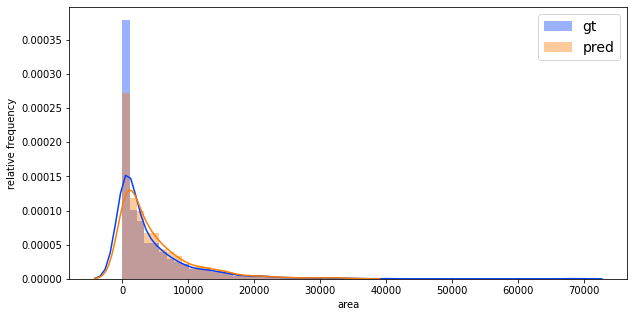

Normalized distance between histograms: 0.619
Bin size: 1123.246


In [6]:
quickplot('area', bin_width_k = 3)

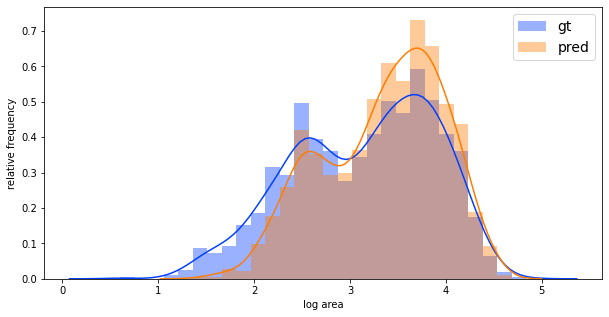

Normalized distance between histograms: 1.362
Bin size: 0.151


In [7]:
quickplot('area', log=True, bin_width_k = 2)

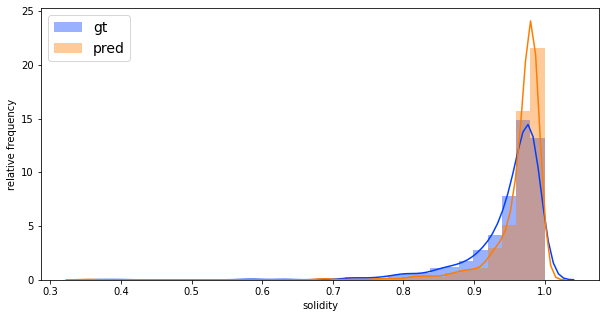

Normalized distance between histograms: 0.917
Bin size: 0.020


In [8]:
quickplot('solidity', bin_width_k = 3)

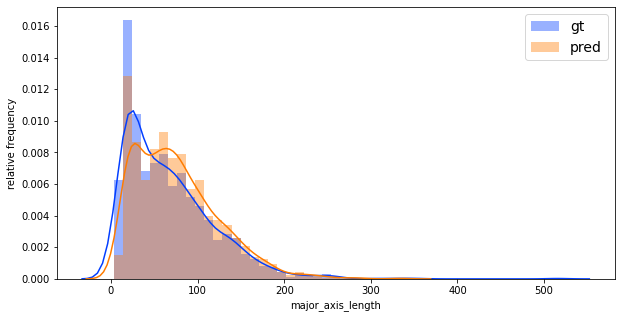

Normalized distance between histograms: 0.792
Bin size: 10.457


In [9]:
quickplot('major_axis_length', bin_width_k = 3)

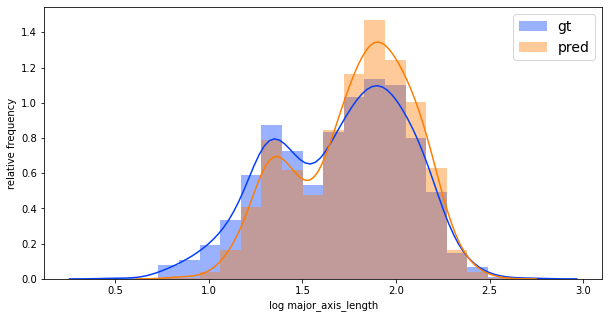

Normalized distance between histograms: 0.757
Bin size: 0.110


In [10]:
quickplot('major_axis_length', log=True, bin_width_k=1.5)